In [1]:
import re, os, sys, glob
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
from fractions import Fraction
from src import pandas_helpers

In [21]:
attendance = pd.read_excel('./data/raw/nba_team_annual_attendance.xlsx')\
               .clean_column_names()\
               .parse_date_columns()

In [22]:
bestLineups = pd.read_csv('./data/raw/nba_player_value/data/bestLineups.csv')\
                .clean_column_names()\
                .parse_date_columns()

In [23]:
lineups_16_17 = pd.read_csv('./data/raw/nba_player_value/data/lineups_16_17.csv')\
                  .clean_column_names()\
                  .parse_date_columns()

In [24]:
nba_positions = pd.read_csv('./data/raw/nba_player_value/data/nba_positions.csv')\
                  .clean_column_names()\
                  .parse_date_columns()

In [18]:
nba_stats = pd.read_csv('./data/raw/nba_player_value/data/nbaStats.csv')\
.clean_column_names()\
.parse_date_columns()

In [19]:
ncaa_positions = pd.read_csv('./data/raw/nba_player_value/data/ncaa_positions.csv')\
.clean_column_names()\
.parse_date_columns()

In [20]:
predictions = pd.read_csv('./data/raw/nba_player_value/data/predictions.csv')\
.clean_column_names()\
.parse_date_columns()

In [9]:
odds = pd.concat(map(pd.read_excel, glob.glob("./data/raw/odds/*.xlsx")))\
.clean_column_names()\
.parse_date_columns()

In [11]:
elo = pd.concat(map(pd.read_csv, glob.glob("./data/raw/nba_elo/nbaallelo.csv")))\
.clean_column_names()\
.parse_date_columns()

In [17]:
test = (
    pd.concat(map(pd.read_csv, glob.glob("./data/welldatabase/test/*.csv")))
    .clean_column_names()
    .parse_date_columns()
    .parse_api_columns()
)

In [18]:
def string_to_fraction(x):
    try:
        result = float(Fraction(x))
    except AttributeError:
        result = float(x)
    except TypeError:
        result = np.nan
    except ValueError:
        result = np.nan
    while result > 1:
        result = result / 64
    return result

In [19]:
test["chokesize_clean"] = (
    test["chokesize"]
    .str.replace("-", "/")
    .str.replace("TH", "")
    .str.strip('"')
    .str.strip("'")
    .str.replace(pat="OPEN|NONE|FO|OPEN FLOW", repl="1")
    .str.replace(pat="0|CLOSED|INSERT", repl="")
    .apply(string_to_fraction)
)

In [20]:
tubingandpacker = (
    pd.concat(map(pd.read_csv, glob.glob("./data/welldatabase/tubingandcasing/*.csv")))
    .clean_column_names()
    .parse_date_columns()
)

In [21]:
header = header[header["wellboreprofile"] == "HORIZONTAL"]
sqdist = (header["surfacelatitude"] - header["bottomholelatitude"]) ** 2 + (
    header["surfacelongitude"] - header["bottomholelongitude"]
) ** 2
header["surface_to_bottomhole_distance"] = sqdist.map(lambda x: np.sqrt(x))

In [22]:
linear_reg = LinearRegression()
xy = header.loc[
    header["surface_to_bottomhole_distance"] != 0,
    ["laterallength", "surface_to_bottomhole_distance"],
].dropna()
y = xy["laterallength"].values.reshape(-1, 1)
X = xy["surface_to_bottomhole_distance"].values.reshape(-1, 1)
linear_reg.fit(X=X, y=y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

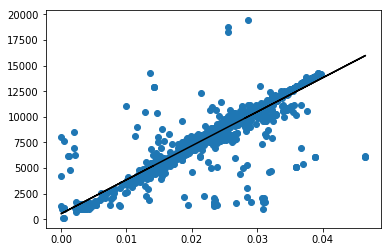

In [23]:
plt.plot(X, y, "o", X, linear_reg.predict(X), "-k")

In [24]:
header["laterallength_from_bottom"] = linear_reg.predict(
    header["surface_to_bottomhole_distance"].values.reshape(-1, 1)
)

In [25]:
header["missing_laterallength"] = header["laterallength"].isnull()

In [26]:
header_summary = header.deduplicate("api", override={"missing_laterallength": "all"})

In [27]:
completion = zero_to_null(completion, ["upperperf", "lowerperf"])

In [28]:
completion_summary = completion.deduplicate(["api", "completiondate"])

In [29]:
index_of_deepest_top = (
    formation.groupby("api").agg({"topdepth": "idxmax"})["topdepth"].dropna()
)
formation_summary = (
    formation.iloc[index_of_deepest_top].groupby("api").agg({"name": "first"})
)

In [30]:
fracstage_summary = fracstage.deduplicate("api")

In [31]:
perf = zero_to_null(perf, ["lowerperf", "upperperf"])

In [32]:
perf_summary = perf.deduplicate("api")

In [33]:
production["yearmonth"] = production["date"].apply(
    lambda x: "{YEAR}-{MONTH:02d}".format(YEAR=x.year, MONTH=x.month)
)

In [34]:
production = production[production["yearmonth"] > "2011-01"]

In [35]:
production["days"] = pd.to_timedelta(production["days"], unit="D")
production["first_producing_day_of_month"] = (
    production["date"] + pd.DateOffset(months=1) - production["days"]
)

In [36]:
production_summary = production.deduplicate(["api", "yearmonth"])

In [37]:
test_summary = test.deduplicate(["api", "testdate"])

In [38]:
productionsummary_summary = productionsummary.deduplicate("api")

In [39]:
combined = (
    header_summary.join(productionsummary_summary, rsuffix="prodsum")
    .join(perf_summary, rsuffix="perf")
    .join(fracstage_summary, rsuffix="frac")
    .merge_multi(test_summary, suffixes=("", "test"))
    .merge_multi(completion_summary, suffixes=("", "comp"))
    .merge_multi(production_summary, suffixes=("", "prod"))
)

In [40]:
combined["days_since_completion"] = (
    combined["first_producing_day_of_month"] - combined["completiondate"]
) / np.timedelta64(1, "D")

In [41]:
combined["increment_30days"] = combined["days_since_completion"].apply(
    lambda x: np.floor(x / 30) + 1
)

In [42]:
combined = combined[
    combined["first_producing_day_of_month"] >= combined["completiondate"]
]
combined.shape

(1089884, 287)

In [43]:
combined_subset = combined[combined["increment_30days"].map(lambda x: 0 <= x <= 12)]
combined_subset.shape

(107540, 287)

In [44]:
combined_subset = combined_subset.deduplicate(
    key=["api", "increment_30days"]
).deduplicate(key=["api"], override={"oil": "sum"})

combined_subset.shape

(1997, 287)

In [45]:
combined_subset.to_csv("./data/welldb_combined.csv")